# 과적합 해결

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

### 배치 정규화 적용

In [32]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [33]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [34]:
class SimpleNN(nn.Module):
    def __init__(self, use_bn=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128) # MNISt 이미지 크기 28 X 28
        # Identity는 아무것도 안함. 그냥 이미지 그대로
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(64, 10) # 최종 10차원으로 출력

    def forward(self, x):
        x = x.view(x.size(0), -1) # 평탄화 (배치크기, h, w) -> (배치 크기, feature)
        x = torch.relu(self.bn1(self.fc1(x))) # fully connected를 batch normalize하고 이후 ReLU
        x = torch.relu(self.bn2(self.fc2(x))) # 첫번째 층의 결과를 두번째 층에서 반복
        x = self.fc3(x) # 내부적으로 softmax 거치고 분류되는 대상에 대한 확률 리턴

        return x

In [35]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct= 0
        with torch.no_grad(): # 검증이기에 기울기 필요 X
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        print(f'Epoch {epoch + 1} | Val Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_data):.4f}')

In [36]:
print('배치 정규화 적용 X')
model_without_bn = SimpleNN(use_bn=False)
train(model_without_bn, train_loader, val_loader)

print('배치 정규화 적용')
model_without_bn = SimpleNN(use_bn=True)
train(model_without_bn, train_loader, val_loader)

배치 정규화 적용 X
Epoch 1 | Val Loss: 0.2636, Accuracy: 0.9205
Epoch 2 | Val Loss: 0.2173, Accuracy: 0.9361
Epoch 3 | Val Loss: 0.2047, Accuracy: 0.9386
Epoch 4 | Val Loss: 0.2229, Accuracy: 0.9368
Epoch 5 | Val Loss: 0.2451, Accuracy: 0.9343
배치 정규화 적용
Epoch 1 | Val Loss: 0.1335, Accuracy: 0.9575
Epoch 2 | Val Loss: 0.1059, Accuracy: 0.9664
Epoch 3 | Val Loss: 0.0889, Accuracy: 0.9718
Epoch 4 | Val Loss: 0.0816, Accuracy: 0.9752
Epoch 5 | Val Loss: 0.0839, Accuracy: 0.9744


In [38]:
for batch_size in [16, 32, 128]:
    print(f'batch_size: {batch_size}')
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn=True)
    train(model, train_loader, val_loader)

batch_size: 16
Epoch 1 | Val Loss: 0.1432, Accuracy: 0.9557
Epoch 2 | Val Loss: 0.1160, Accuracy: 0.9647
Epoch 3 | Val Loss: 0.1114, Accuracy: 0.9647
Epoch 4 | Val Loss: 0.0881, Accuracy: 0.9722
Epoch 5 | Val Loss: 0.0937, Accuracy: 0.9714
batch_size: 32
Epoch 1 | Val Loss: 0.1248, Accuracy: 0.9610
Epoch 2 | Val Loss: 0.0981, Accuracy: 0.9701
Epoch 3 | Val Loss: 0.0814, Accuracy: 0.9742
Epoch 4 | Val Loss: 0.0899, Accuracy: 0.9727
Epoch 5 | Val Loss: 0.0951, Accuracy: 0.9685
batch_size: 128
Epoch 1 | Val Loss: 0.1207, Accuracy: 0.9629
Epoch 2 | Val Loss: 0.0905, Accuracy: 0.9722
Epoch 3 | Val Loss: 0.0920, Accuracy: 0.9720
Epoch 4 | Val Loss: 0.0853, Accuracy: 0.9752
Epoch 5 | Val Loss: 0.0837, Accuracy: 0.9746


### 드롭아웃 적용

In [44]:
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), - 1)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [45]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

for rate in [0.2, 0.5, 0.8]:
    print(f'Dropout Rate: {rate}')
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)

Dropout Rate: 0.2
Epoch 1 | Val Loss: 0.2914, Accuracy: 0.9042
Epoch 2 | Val Loss: 0.2783, Accuracy: 0.9148
Epoch 3 | Val Loss: 0.2753, Accuracy: 0.9161
Epoch 4 | Val Loss: 0.2581, Accuracy: 0.9252
Epoch 5 | Val Loss: 0.3257, Accuracy: 0.9014
Dropout Rate: 0.5
Epoch 1 | Val Loss: 0.6025, Accuracy: 0.8488
Epoch 2 | Val Loss: 0.5009, Accuracy: 0.8592
Epoch 3 | Val Loss: 0.5389, Accuracy: 0.8636
Epoch 4 | Val Loss: 0.5477, Accuracy: 0.8453
Epoch 5 | Val Loss: 0.4779, Accuracy: 0.8716
Dropout Rate: 0.8
Epoch 1 | Val Loss: 2.1425, Accuracy: 0.1908
Epoch 2 | Val Loss: 2.2143, Accuracy: 0.1869
Epoch 3 | Val Loss: 2.1567, Accuracy: 0.1955
Epoch 4 | Val Loss: 2.1692, Accuracy: 0.2047
Epoch 5 | Val Loss: 2.1347, Accuracy: 0.2079


In [46]:
model = DropoutNN(dropout_rate=0.2)

In [ ]:
model.eval() # 드롭아웃 적용 X
with torch.no_grad(): 
    images, _ = next(iter(val_loader)) # 배치 중 하나만 꺼내옴.
    images = images.view(images.size(0), -1)

    out1 = model(images)
    out2 = model(images)

    print(torch.allclose(out1, out2))

True


In [ ]:
model.train() # 드롭아웃 적용

out1 = model(images)
out2 = model(images)

print(torch.allclose(out1, out2))

False


### learning rate scheduler 적용

In [54]:
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [55]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=5):
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct= 0
        with torch.no_grad(): # 검증이기에 기울기 필요 X
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        scheduler.step()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_data):.4f}, learningRate: {scheduler.get_last_lr()[0]}')

In [ ]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) # epoch 3번마다 학습률에 gamma값을 곱함

train_lr(model, train_loader, val_loader, optimizer, scheduler)

Epoch 1 | Val Loss: 0.2292, Accuracy: 0.9298, learningRate: 0.01
Epoch 2 | Val Loss: 0.2012, Accuracy: 0.9393, learningRate: 0.01
Epoch 3 | Val Loss: 0.2119, Accuracy: 0.9370, learningRate: 0.001
Epoch 4 | Val Loss: 0.1339, Accuracy: 0.9603, learningRate: 0.001
Epoch 5 | Val Loss: 0.1335, Accuracy: 0.9610, learningRate: 0.001


### 조기 종료 적용

In [57]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)


        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if early_stopping and early_stopping(val_loss):
            print(f'조기종료 epoch {epoch + 1}')
            break
        
    return train_losses, val_losses

In [58]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

In [59]:
model_no_es = RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.01)
train_losses, val_losses = train_es(model_no_es, train_loader, val_loader, optim_no_es)

model_es = RealSimpleNN()
optim_es = optim.Adam(model_es.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=5)
train_es_losses, val_es_losses = train_es(model_es, train_loader, val_loader, optim_es, early_stopping=early_stopping)

Epoch 1 | Loss: 0.2852, Accuracy: 0.9117
Epoch 2 | Loss: 0.2068, Accuracy: 0.9391
Epoch 3 | Loss: 0.1928, Accuracy: 0.9395
Epoch 4 | Loss: 0.1731, Accuracy: 0.9475
Epoch 5 | Loss: 0.1674, Accuracy: 0.9506
Epoch 6 | Loss: 0.1813, Accuracy: 0.9477
Epoch 7 | Loss: 0.1748, Accuracy: 0.9486
Epoch 8 | Loss: 0.2181, Accuracy: 0.9427
Epoch 9 | Loss: 0.1826, Accuracy: 0.9465
Epoch 10 | Loss: 0.1798, Accuracy: 0.9529
Epoch 11 | Loss: 0.1633, Accuracy: 0.9531
Epoch 12 | Loss: 0.1933, Accuracy: 0.9492
Epoch 13 | Loss: 0.1763, Accuracy: 0.9549
Epoch 14 | Loss: 0.1876, Accuracy: 0.9489
Epoch 15 | Loss: 0.1841, Accuracy: 0.9534
Epoch 16 | Loss: 0.1875, Accuracy: 0.9529
Epoch 17 | Loss: 0.1713, Accuracy: 0.9554
Epoch 18 | Loss: 0.2025, Accuracy: 0.9466
Epoch 19 | Loss: 0.2072, Accuracy: 0.9511
Epoch 20 | Loss: 0.2706, Accuracy: 0.9343
Epoch 21 | Loss: 0.2078, Accuracy: 0.9481
Epoch 22 | Loss: 0.1672, Accuracy: 0.9537
Epoch 23 | Loss: 0.2166, Accuracy: 0.9482
Epoch 24 | Loss: 0.2299, Accuracy: 0.9442
E

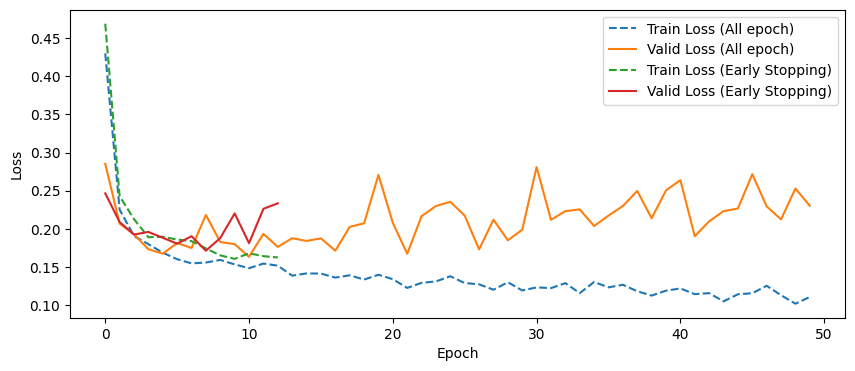

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss (All epoch)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (All epoch)')
plt.plot(train_es_losses, label='Train Loss (Early Stopping)', linestyle='dashed')
plt.plot(val_es_losses, label='Valid Loss (Early Stopping)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### L2 적용

In [61]:
def train_reg(model, trian_loader, val_loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    weight_norms = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)


        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'epoch {epoch + 1} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        weight_norm = sum(torch.norm(p).item() for p in model.parameters())
        weight_norms.append(weight_norm)

    return train_losses, val_losses, weight_norms

In [62]:
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0.0, momentum= 0.9)
train_losses, val_losses, weight_norms = train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)

model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weight_decay=0.01, momentum= 0.9)
train_reg_losses, val_reg_losses, weight_norms_reg = train_reg(model_reg, train_loader, val_loader, optim_reg)

epoch 1 | Train Loss: 0.6406, Val Loss: 0.3191, Accuracy: 0.9044
epoch 2 | Train Loss: 0.2636, Val Loss: 0.2233, Accuracy: 0.9304
epoch 3 | Train Loss: 0.1943, Val Loss: 0.1759, Accuracy: 0.9443
epoch 4 | Train Loss: 0.1555, Val Loss: 0.1433, Accuracy: 0.9560
epoch 5 | Train Loss: 0.1289, Val Loss: 0.1245, Accuracy: 0.9604
epoch 6 | Train Loss: 0.1112, Val Loss: 0.1272, Accuracy: 0.9593
epoch 7 | Train Loss: 0.0978, Val Loss: 0.1120, Accuracy: 0.9646
epoch 8 | Train Loss: 0.0856, Val Loss: 0.1085, Accuracy: 0.9666
epoch 9 | Train Loss: 0.0761, Val Loss: 0.1109, Accuracy: 0.9643
epoch 10 | Train Loss: 0.0682, Val Loss: 0.0978, Accuracy: 0.9680
epoch 1 | Train Loss: 0.6601, Val Loss: 0.3736, Accuracy: 0.8821
epoch 2 | Train Loss: 0.3157, Val Loss: 0.2957, Accuracy: 0.9110
epoch 3 | Train Loss: 0.2686, Val Loss: 0.2472, Accuracy: 0.9276
epoch 4 | Train Loss: 0.2399, Val Loss: 0.2257, Accuracy: 0.9374
epoch 5 | Train Loss: 0.2217, Val Loss: 0.2353, Accuracy: 0.9264
epoch 6 | Train Loss: 0.

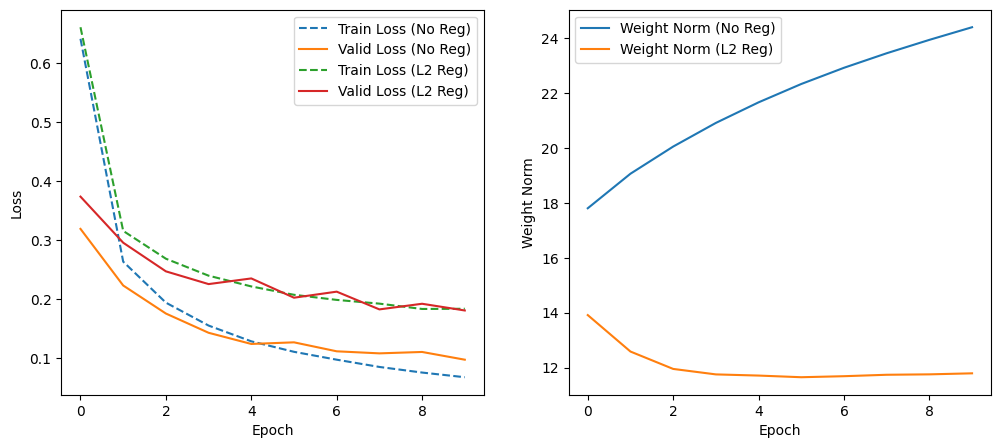

In [63]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss (No Reg)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (No Reg)')
plt.plot(train_reg_losses, label='Train Loss (L2 Reg)', linestyle='dashed')
plt.plot(val_reg_losses, label='Valid Loss (L2 Reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(weight_norms, label='Weight Norm (No Reg)')
plt.plot(weight_norms_reg, label='Weight Norm (L2 Reg)')
plt.xlabel('Epoch')
plt.ylabel('Weight Norm')
plt.legend()

plt.show()